# Segment foreground

This notebook takes scans of block-samples and automatically or semi-automatically segments individual samples to create a spectral library.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import path, patches

import hylite
import hylite.io as io
from hylite.filter import label_blocks
from hylite.analyse import getClassLibrary

Load radiance scans from directory

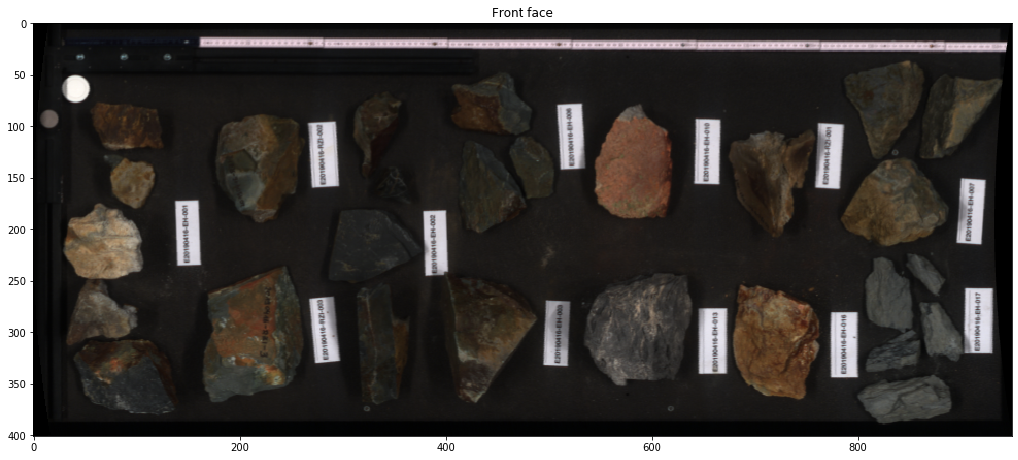

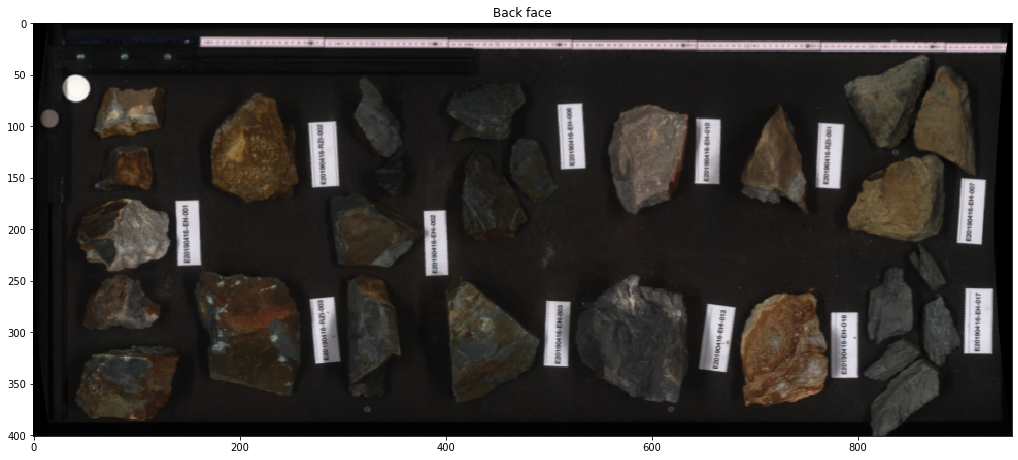

In [2]:
front_face = '/Users/thiele67/Documents/Data/CA/Scanner/white panel/reflectance/batch 1_orientation2_whitepanel_CA 2019_0035_CA2019_5_5m00_6m00.hdr'
back_face = '/Users/thiele67/Documents/Data/CA/Scanner/white panel/reflectance/batch1_orientation1_whitepanel_CA 2019_0032_CA2019_2_2m00_3m00.hdr'

front = io.loadWithGDAL( front_face )
fig,ax = front.quick_plot(hylite.RGB)
ax.set_title("Front face")
fig.show()

if not back_face is None:
    back = io.loadWithGDAL( back_face )
    fig,ax = back.quick_plot(hylite.RGB)
    ax.set_title("Back face")
    fig.show()
else:
    back = None

## Define sample numbers and front face/back face pairs

In [3]:
sample_IDs = ["EH-001",
              "RZI-003",
              "RZI-002",
              "EH-002",
              "EH-003",
              "EH-006",
              "EH-013",
              "EH-010",
              "EH-016",
              "RZI-001",
              "EH-017",
              "EH-007"]

## Extract point-spectra from samples for spectral library (and as seeds for segmentation)

In [8]:
fpoints = [] #frontface points per sample
bpoints = [] #backface points per sample
for s in sample_IDs:
    fpoints.append( front.pickPoints(title="Front face: %s" % s) )
    if back is not None:
        bpoints.append( back.pickPoints(title="Back face: %s" % s))
%matplotlib inline

Add reference points into header

In [14]:
for image,points in [(front,fpoints),(back,bpoints)]:
    if not image is None:
        image.header['class names'] = sample_IDs # names of samples
        image.header['classes'] = len(sample_IDs) # number of samples
        for i,sample in enumerate(sample_IDs): # add sample points
            image.header['sample %s' % sample] = points[i]

In [15]:
io.saveHeader( io.matchHeader(front_face)[0], front.header)
if back is not None:
    io.saveHeader( io.matchHeader(back_face)[0], back.header)

### Plot sample spectra

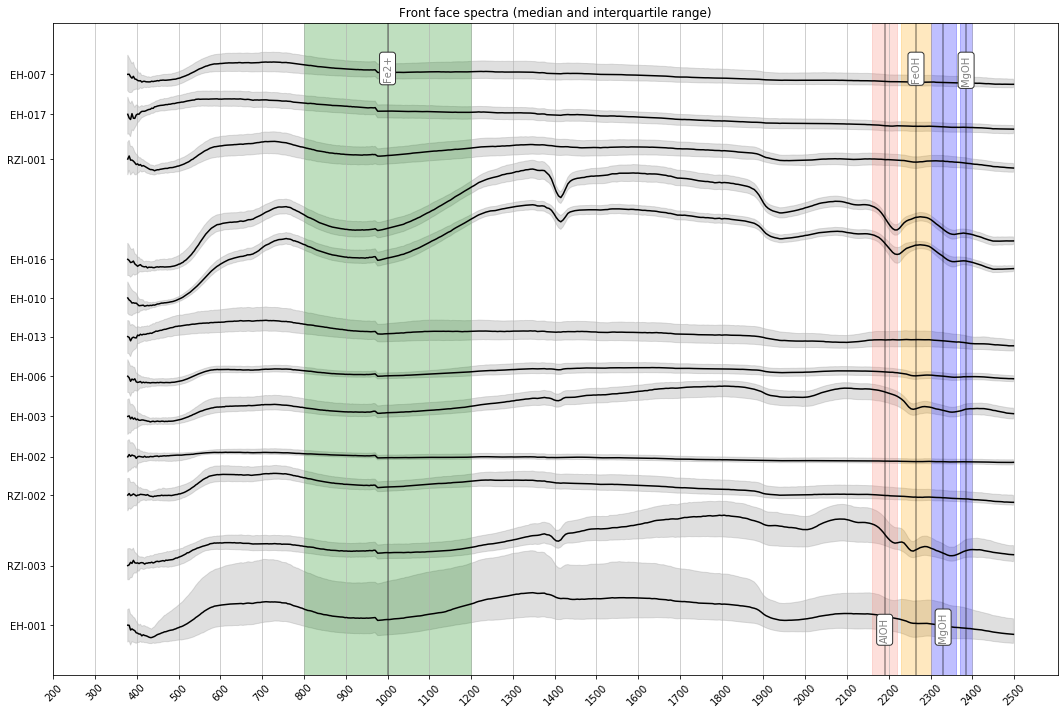

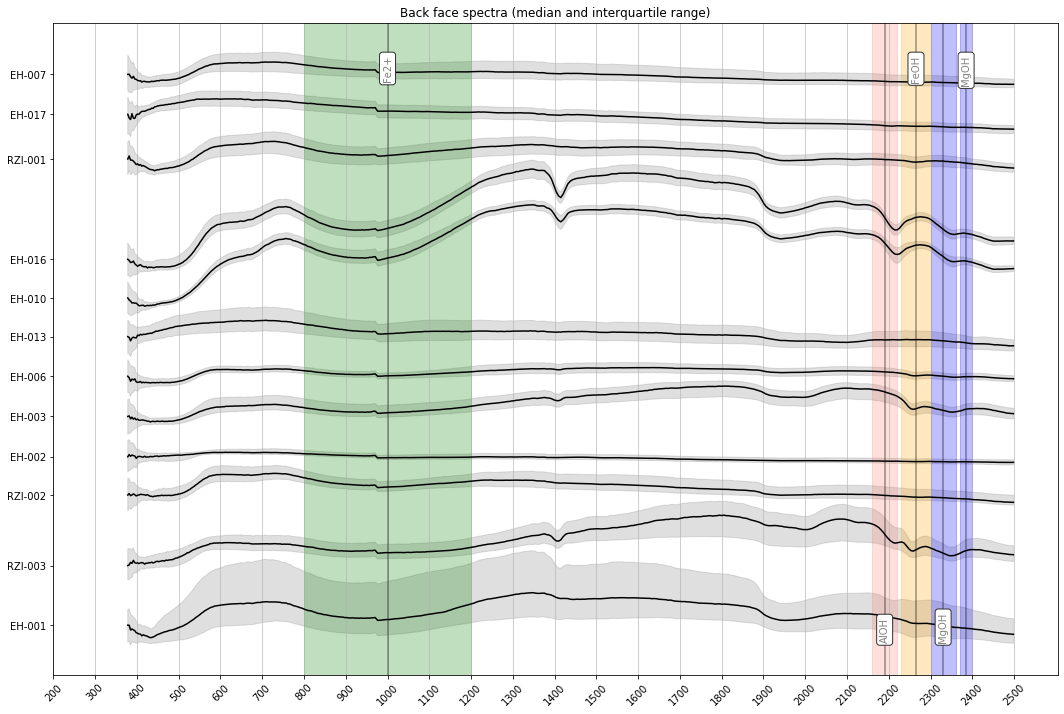

In [4]:
library = front.getSpectralLibrary()
fig,ax = library.quick_plot()
ax.set_title("Front face spectra (median and interquartile range)")
fig.show()

if back is not None:
    library = front.getSpectralLibrary()
    fig,ax = library.quick_plot()
    ax.set_title("Back face spectra (median and interquartile range)")
    fig.show()

### Attempt foreground/background segmentation using grab-cut

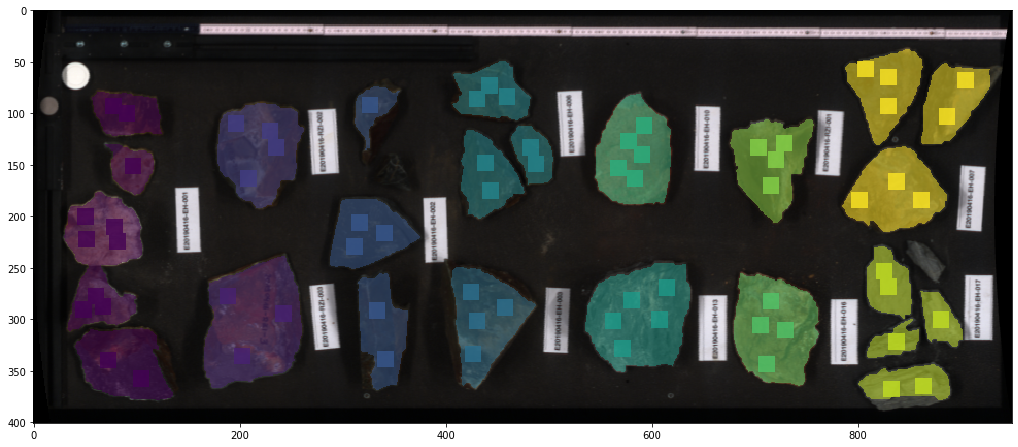

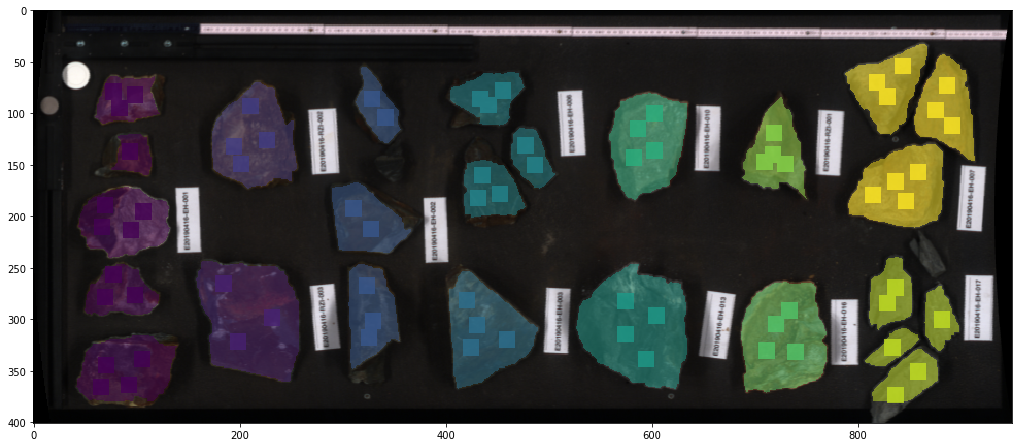

In [5]:
front_cls = label_blocks( front, boost=5, vb=True )
if back is not None:
    back_cls = label_blocks( back, boost=5, vb=True )

### Extract updated spectral library using whole sample blocks

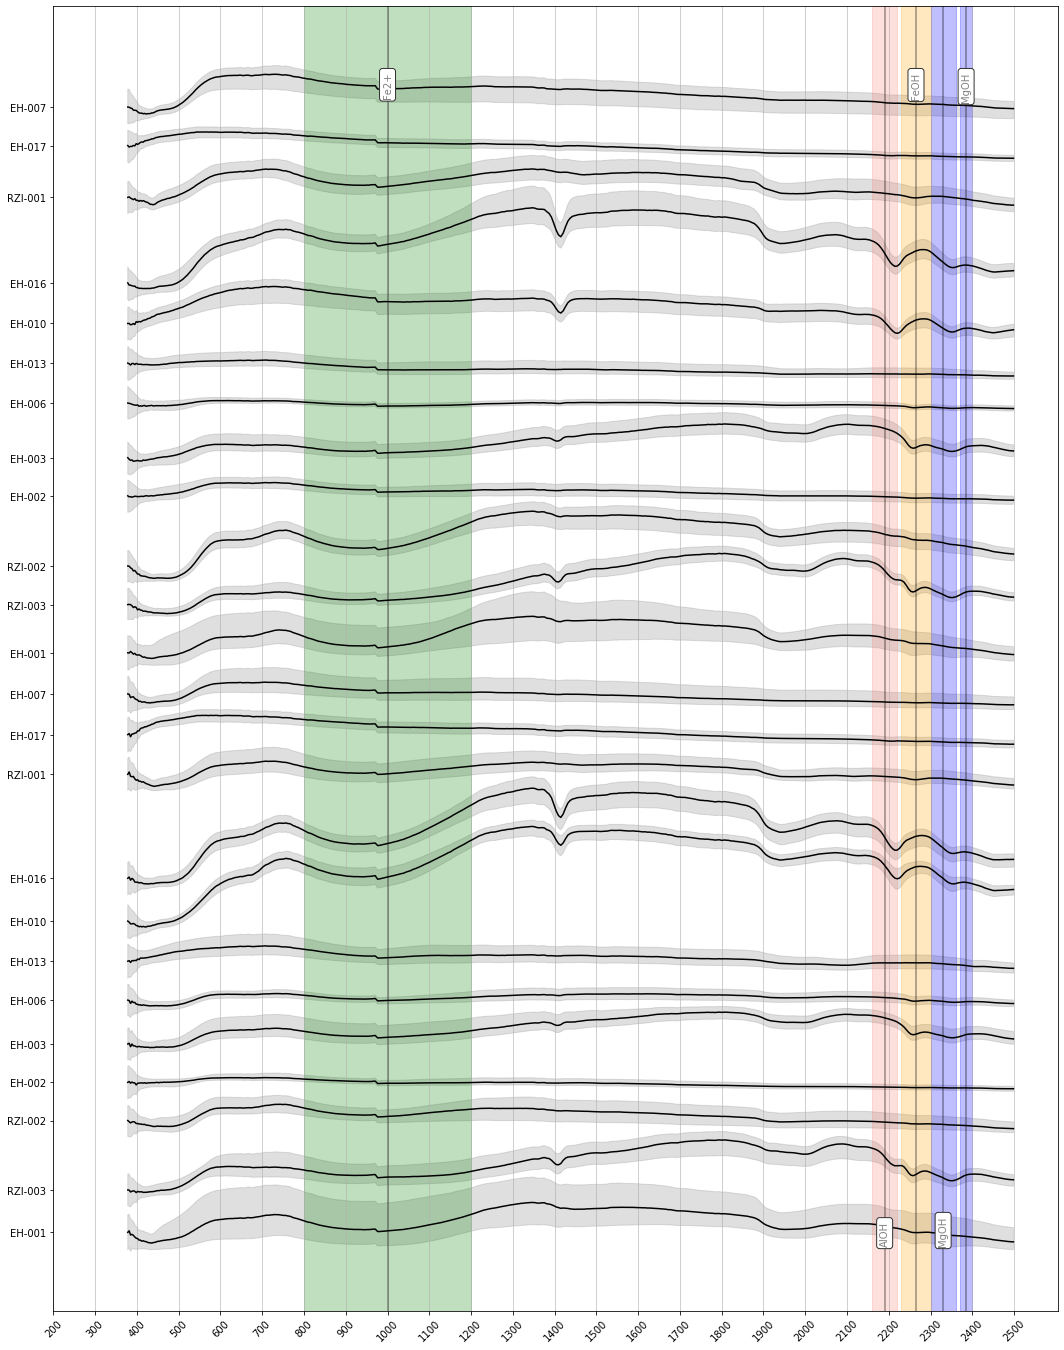

In [15]:
library = getClassLibrary( front, front_cls )
if not back is None:
    library = library.merge( getClassLibrary( back, back_cls ) )
fig,ax = library.quick_plot()
fig.show()

### Save classifications and library

In [12]:
# save classification
front_face_cls = os.path.splitext(front_face)[0] + '_labels.cls.hdr'
io.saveWithGDAL( front_face_cls, front_cls)

if back is not None:
    back_face_cls = os.path.splitext(back_face)[0] + '_labels.cls.hdr'
    io.saveWithGDAL( back_face_cls, back_cls )

In [11]:
# save library
io.saveLibraryCSV( '/Users/thiele67/Documents/Data/CA/Scanner/samples.csv', library )